## Code Based on https://www.kaggle.com/ksaaskil/neural-style-transfer-for-art-images-using-keras

In [207]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from keras.applications import vgg19
%matplotlib inline
from tensorflow import keras
import sys
import scipy
#from libs import utils
sys.modules['keras'] = keras

target_image_path="monet_images/impression-sunrise.jpg"
style_reference_image_path="turner_image/the-burning-of-the-houses-of-parliament-1.jpg"

In [208]:
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [186]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)# adds channel
    img = np.expand_dims(img, axis=0)#adds the number of images
    img = vgg19.preprocess_input(img) #adequate the image to the format the model requires -1 to 1
    return img

print("Shape of preprocessed target image:", preprocess_image(target_image_path).shape)
print("Shape of preprocessed reference image:", preprocess_image(style_reference_image_path).shape)

Shape of preprocessed target image: (1, 500, 610, 3)
Shape of preprocessed reference image: (1, 500, 610, 3)


In [187]:
def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    #'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')#0 to 255 rgb
    return x

In [188]:
from keras import backend as K
target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
# The placeholder will contain generated image
combination_image = K.placeholder((1, img_height, img_width, 3))
#combine the 3 images into a single input
input_tensor = K.concatenate([target_image, style_reference_image, combination_image], axis=0)

# load with the pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                   weights='imagenet',
                   include_top=False)

In [189]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (3, 500, 610, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 500, 610, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 500, 610, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 250, 305, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 250, 305, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 250, 305, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 125, 152, 128)        0         
__________

In [190]:
#Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1_5/Relu:0' shape=(3, 500, 610, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_5/Relu:0' shape=(3, 500, 610, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_5/MaxPool:0' shape=(3, 250, 305, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_5/Relu:0' shape=(3, 250, 305, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_5/Relu:0' shape=(3, 250, 305, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_5/MaxPool:0' shape=(3, 125, 152, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_5/Relu:0' shape=(3, 125, 152, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_5/Relu:0' shape=(3, 125, 152, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_5/Relu:0' shape=(3, 125, 152, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_5/Relu:0' shape=(3, 125, 152, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_5/MaxPool:0' shape=(3, 62, 76, 

In [191]:
def content_loss(base, combination):
    return K.sum(K.square(combination-base))

def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


In [192]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [193]:
class Evaluator:
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
    
evaluator = Evaluator()

In [194]:
# layer used for content loss
content_layer = 'block5_conv2'
# layer used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
#Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.5
content_weight = 0.015

## Define the loss by adding all components to a `loss` variable
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = K.variable(0.)
loss = loss+content_weight * content_loss(target_image_features, combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
    
loss = loss+total_variation_weight * total_variation_loss(combination_image)

In [195]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]
# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

Start of iteration: 0
Current loss value: 1133741700.0
Image saved as results_at_iteration_0.png


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


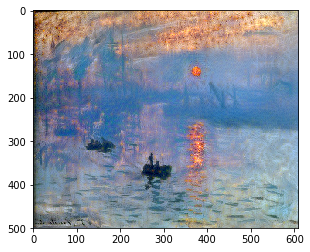

Iteration 0 completes in 308 s
Start of iteration: 1
Current loss value: 541319230.0
Image saved as results_at_iteration_1.png


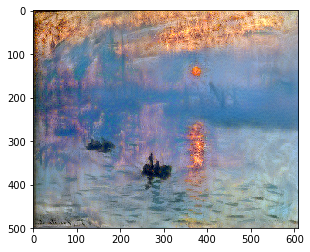

Iteration 1 completes in 308 s
Start of iteration: 2
Current loss value: 410118500.0
Image saved as results_at_iteration_2.png


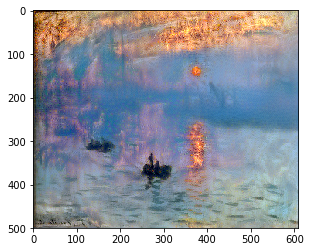

Iteration 2 completes in 308 s
Start of iteration: 3
Current loss value: 348724030.0
Image saved as results_at_iteration_3.png


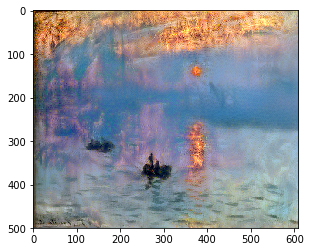

Iteration 3 completes in 308 s
Start of iteration: 4
Current loss value: 304627170.0
Image saved as results_at_iteration_4.png


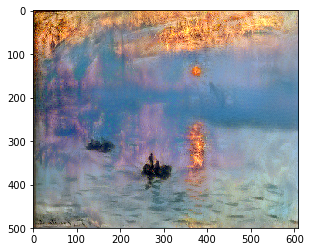

Iteration 4 completes in 308 s
Start of iteration: 5
Current loss value: 277033820.0
Image saved as results_at_iteration_5.png


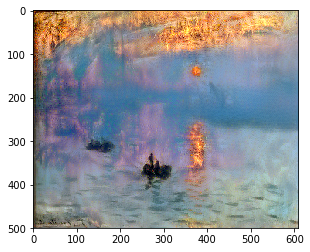

Iteration 5 completes in 308 s
Start of iteration: 6
Current loss value: 252585490.0
Image saved as results_at_iteration_6.png


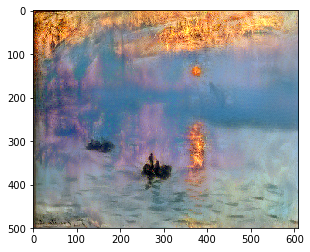

Iteration 6 completes in 309 s
Start of iteration: 7
Current loss value: 232676400.0
Image saved as results_at_iteration_7.png


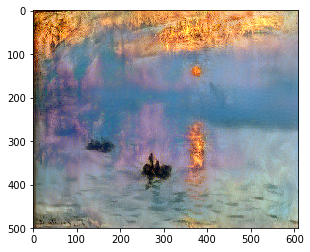

Iteration 7 completes in 308 s
Start of iteration: 8
Current loss value: 216675140.0
Image saved as results_at_iteration_8.png


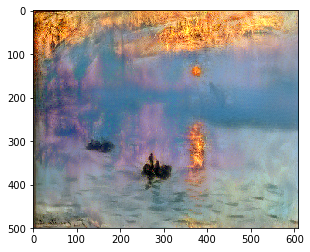

Iteration 8 completes in 309 s
Start of iteration: 9
Current loss value: 202393800.0
Image saved as results_at_iteration_9.png


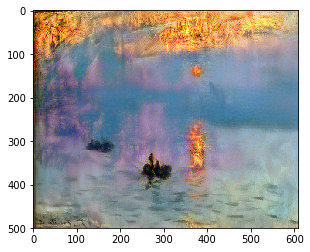

Iteration 9 completes in 467 s


In [196]:
from scipy.optimize import fmin_l_bfgs_b # Using SciPy's L-BFGS algorithm
from scipy.misc import imsave
import time

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image to minimize the neural style loss.

result_folder = 'results/'
iterations = 12
x = preprocess_image(target_image_path)
# scipy.optimize.fmin_l_bfgs_b can only process flat vectors, so flatten needed
x = x.flatten()

for i in range(iterations):
    print('Start of iteration: {}'.format(i))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                    x,
                                    fprime=evaluator.grads,
                                    maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    file = result_folder + '_at_iteration_%d.png' % i
    imsave(file, img)
    print('Image saved as', file)
    plt.imshow(img)
    plt.show()
    end_time = time.time()
    print('Iteration %d completes in %d s' % (i, end_time - start_time))
    
    

<Figure size 432x288 with 0 Axes>

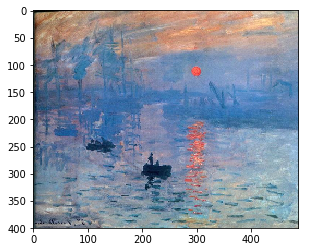

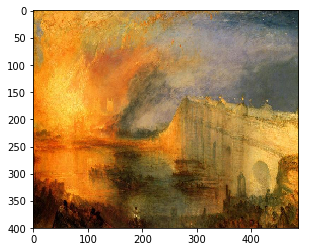

<Figure size 432x288 with 0 Axes>

In [209]:
# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

In [197]:
def visualize_kernel(layer_idx,img):
    layer = model.layers[layer_idx]
    layer_weight=layer.get_weights()[0]
    nb_kernel=layer_weight.shape[3]
    title="conv{} layer kernal".format(layer_idx)
    fig, axes =  plt.subplots(nb_kernel, 4, figsize=(8, nb_kernel*2))
    for i in range(0, nb_kernel):
        for e in range(4):
        # Get kernel from the layer and draw it
            kernel=layer_weight[:,:,:3,i]
        
        
        # adding weight 
            img_filt = scipy.ndimage.filters.convolve(img, kernel)
            axes[i][e].imshow((img_filt* 255 ), vmin=0, vmax=255)
        
        
    plt.suptitle(title)
    plt.tight_layout( )
    plt.subplots_adjust(top=0.95)
    plt.show() 

In [205]:
s=load_img(style_reference_image_path, target_size=(img_height, img_width))
c=load_img(target_image_path, target_size=(img_height, img_width))

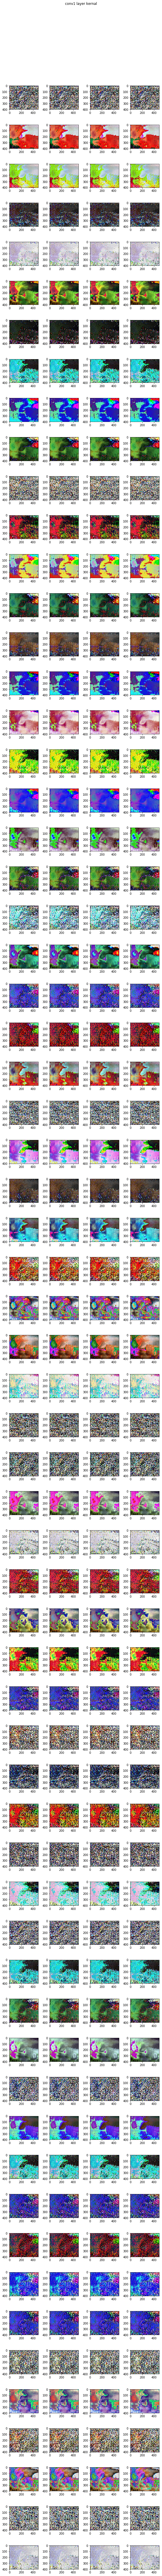

In [210]:
visualize_kernel(1,s)# see how the second layer kernel captures the feature of style  image